In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from keras.layers import Dropout
from sklearn.metrics import mean_squared_error
from keras import optimizers

# Prepare Data

In [3]:
def preparedata(file):
    cloud_cover = pd.read_csv(file, skipinitialspace = True)
    cloud_cover['Date'] = cloud_cover[['Year', 'Month', 'Day']].apply(lambda x: "{0}-{1}-{2}".format(str(x[0]).zfill(2), str(x[1]).zfill(2), str(x[2]).zfill(2)), axis=1) 
    cloud_cover['Time'] = cloud_cover[['Hour', 'Minute']].apply(lambda x: "{}:{}".format(str(x[0]).zfill(2), str(x[1]).zfill(2)), axis=1)
    cloud_cover.drop(["Year", "Month", "Day", "Hour", "Minute", "Second"], axis=1, inplace=True)  
    cloud_cover = cloud_cover.rename(columns={"CloudCover":"cloud_cover"})
    cloud_cover = cloud_cover.groupby(['Date', 'Time']).agg(cloud_cover=('cloud_cover','mean')).reset_index()
    cloud_cover['DateTime'] = cloud_cover[['Date', 'Time']].apply(lambda x: "{} {}".format(str(x[0]).zfill(2), str(x[1]).zfill(2)), axis=1)
    cloud_cover.drop(["Date", "Time"], axis=1, inplace=True)        
    cloud_cover['DateTime'] = pd.to_datetime(cloud_cover['DateTime'], format="%Y-%m-%d %H:%M")
    cloud_cover.dropna(inplace=True)
    return cloud_cover


In [4]:
cloud_cover = preparedata('../prophet_ver2/Bangkhuntean_CloudCover_2021-16Nov-16Dec.csv')
cloud_cover

cloud_cover            DateTime
0         0.990000 2021-11-16 11:15:00
1         0.989000 2021-11-16 11:16:00
2         0.987667 2021-11-16 11:17:00
3         0.987000 2021-11-16 11:18:00
4         0.987000 2021-11-16 11:19:00
...            ...                 ...
15056     0.168000 2021-12-16 13:58:00
15057     0.169000 2021-12-16 13:59:00
15058     0.147000 2021-12-16 14:00:00
15059     0.145000 2021-12-16 14:01:00
15060     0.144000 2021-12-16 14:02:00

[15061 rows x 2 columns]

In [5]:
def lags_train_test(data, lags):
	X, y = [], []
	for i in range(lags, len(data)):
		X.append(data[i-lags:i])
		y.append(data[i])
	return np.array(X), np.array(y)

In [6]:
def Xtrain_ytrain(train,test,lags):
    #scale train
    sc = MinMaxScaler()
    sc.fit(train)
    train_set_scale = sc.transform(train)
    # train
    X_train, y_train = lags_train_test(train_set_scale, lags)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    print("X_train Shape :", X_train.shape)
    print("y_train Shape :", y_train.shape)

    #scale test
    dataset_total = pd.concat((train['cloud_cover'], test['cloud_cover']), axis=0)
    inputs = dataset_total[len(dataset_total) - len(test) - lags:].values
    inputs = inputs.reshape(-1,1)
    inputs = sc.transform(inputs)
    # test
    X_test, y_test = lags_train_test(inputs, lags)
    print("X_test Shape : ", X_test.shape)
    print("y_test Shape : ", y_test.shape)
    return X_train, y_train, X_test, y_test, sc

In [7]:
def plot_curve(history):
    # loss curves
    fig1 = plt.figure(figsize=[8,6])
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(loss) + 1)

    plt.plot(epochs, loss, 'orange', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

In [8]:
def plot_curve(history):
    # loss curves
    fig1 = plt.figure(figsize=[8,6])
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(loss) + 1)

    plt.plot(epochs, loss, 'orange', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

In [9]:
def plot_test(train,pred):
    fig2 = go.Figure()
    fig2.add_trace(go.Scatter(mode = 'lines', x = train['DateTime'], y = train['cloud_cover'], name = 'Train'))
    fig2.add_trace(go.Scatter(mode = 'lines', x = pred['DateTime'], y = pred['cloud_cover'], name = 'Actual'))
    fig2.add_trace(go.Scatter(mode = 'lines', x = pred['DateTime'], y = pred['LSTM'], name = 'Predict'))
    fig2.update_layout(
    autosize=True,
    height=600,
    title="LSTM Model",
    xaxis_title="Date",
    yaxis_title="Cloud cover",
    )


    fig2.update_layout(
        xaxis=dict(
            rangeselector=dict(
                buttons=list([
                    dict(count=1,
                        label="1.zoom",
                        step="hour",
                        stepmode="backward"),
                    dict(count=2,
                        label="2.zoom",
                        step="hour",
                        stepmode="backward"),
                    dict(count=3,
                        label="3.zoom",
                        step="day",
                        stepmode="backward"),              

                    dict(step="all")
                ])
            ),
            rangeslider=dict(
                visible=True
            ),
            type="date"
        )
    )

    fig2.show()

# Train/Test Model

In [10]:
train = cloud_cover[cloud_cover['DateTime'] < '2021-12-16 00:00:00']
test = cloud_cover[cloud_cover['DateTime'] >= '2021-12-16 00:00:00']

print('Train Shape', train.shape)
print('Test Shape', test.shape)

Train Shape (14768, 2)
Test Shape (293, 2)


In [11]:
train

cloud_cover            DateTime
0         0.990000 2021-11-16 11:15:00
1         0.989000 2021-11-16 11:16:00
2         0.987667 2021-11-16 11:17:00
3         0.987000 2021-11-16 11:18:00
4         0.987000 2021-11-16 11:19:00
...            ...                 ...
14763     0.321000 2021-12-15 16:55:00
14764     0.304000 2021-12-15 16:56:00
14765     0.286000 2021-12-15 16:57:00
14766     0.344000 2021-12-15 16:58:00
14767     0.328000 2021-12-15 16:59:00

[14768 rows x 2 columns]

In [73]:
test

cloud_cover
DateTime                        
2021-12-16 09:10:00        0.111
2021-12-16 09:11:00        0.112
2021-12-16 09:12:00        0.116
2021-12-16 09:13:00        0.112
2021-12-16 09:14:00        0.099
...                          ...
2021-12-16 13:58:00        0.168
2021-12-16 13:59:00        0.169
2021-12-16 14:00:00        0.147
2021-12-16 14:01:00        0.145
2021-12-16 14:02:00        0.144

[293 rows x 1 columns]

In [13]:
train = train.set_index('DateTime')
test = test.set_index('DateTime')

## Lag 5

In [14]:
# X_train, y_train, X_test and y_test
X_train, y_train, X_test, y_test, sc = Xtrain_ytrain(train,test,5)

X_train Shape : (14763, 5, 1)
y_train Shape : (14763, 1)
X_test Shape :  (293, 5, 1)
y_test Shape :  (293, 1)


c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


### Add frist layer: units = 50 and Add Dropout = 0.1

In [15]:
model_1 = Sequential()
model_1.add(LSTM(units = 50, return_sequences = False, input_shape = (X_train.shape[1], 1)))
model_1.add(Dropout(0.1))
model_1.add(Dense(units = 1))
opt = optimizers.Adam(learning_rate=0.005)
model_1.compile(optimizer = opt, loss = 'mean_squared_error')
hist = model_1.fit(X_train, y_train, validation_data=(X_test, y_test), epochs = 10, batch_size = 32)

Epoch 1/10
462/462 [==============================] - 8s 9ms/step - loss: 0.0069 - val_loss: 0.0035
Epoch 2/10
462/462 [==============================] - 2s 5ms/step - loss: 0.0026 - val_loss: 0.0027
Epoch 3/10
462/462 [==============================] - 2s 5ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 4/10
462/462 [==============================] - 3s 6ms/step - loss: 0.0019 - val_loss: 0.0021
Epoch 5/10
462/462 [==============================] - 4s 8ms/step - loss: 0.0017 - val_loss: 0.0019
Epoch 6/10
462/462 [==============================] - 2s 5ms/step - loss: 0.0016 - val_loss: 0.0023
Epoch 7/10
462/462 [==============================] - 2s 4ms/step - loss: 0.0016 - val_loss: 0.0019
Epoch 8/10
462/462 [==============================] - 2s 4ms/step - loss: 0.0015 - val_loss: 0.0019
Epoch 9/10
462/462 [==============================] - 2s 4ms/step - loss: 0.0015 - val_loss: 0.0018
Epoch 10/10
462/462 [==============================] - 2s 4ms/step - loss: 0.0016 - val_loss: 0.0019

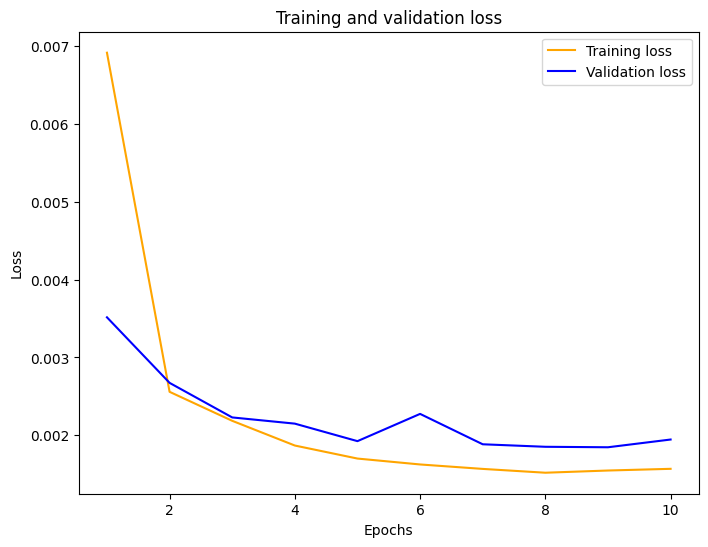

In [16]:
plot_curve(hist)

In [17]:
predict_scaled = model_1.predict(X_test)
predict = sc.inverse_transform(predict_scaled)
predict

10/10 [==============================] - 1s 2ms/step


array([[0.3407516 ],
       [0.13548368],
       [0.10022806],
       [0.11373153],
       [0.1180964 ],
       [0.10910858],
       [0.1023566 ],
       [0.1184023 ],
       [0.12366951],
       [0.12927838],
       [0.12773527],
       [0.12200707],
       [0.12488898],
       [0.1294786 ],
       [0.13009943],
       [0.13082927],
       [0.13266839],
       [0.125262  ],
       [0.14102364],
       [0.1487119 ],
       [0.15549798],
       [0.14734808],
       [0.1423535 ],
       [0.14579676],
       [0.14666359],
       [0.15626568],
       [0.16429311],
       [0.16667815],
       [0.17112198],
       [0.17228778],
       [0.16632022],
       [0.17000148],
       [0.1689248 ],
       [0.17526092],
       [0.16203436],
       [0.14814699],
       [0.1630642 ],
       [0.17678103],
       [0.19061546],
       [0.18595704],
       [0.1916114 ],
       [0.20762314],
       [0.23607805],
       [0.2531316 ],
       [0.26205164],
       [0.27892783],
       [0.29225132],
       [0.297

In [18]:
train0 = train.copy()
test0 = test.copy()

In [19]:
train0.reset_index(inplace=True)
test0.reset_index(inplace=True)

In [20]:
test0['LSTM'] = predict
test0

DateTime  cloud_cover      LSTM
0   2021-12-16 09:10:00        0.111  0.340752
1   2021-12-16 09:11:00        0.112  0.135484
2   2021-12-16 09:12:00        0.116  0.100228
3   2021-12-16 09:13:00        0.112  0.113732
4   2021-12-16 09:14:00        0.099  0.118096
..                  ...          ...       ...
288 2021-12-16 13:58:00        0.168  0.177872
289 2021-12-16 13:59:00        0.169  0.177535
290 2021-12-16 14:00:00        0.147  0.178540
291 2021-12-16 14:01:00        0.145  0.157819
292 2021-12-16 14:02:00        0.144  0.152719

[293 rows x 3 columns]

In [21]:
plot_test(train0,test0)

In [22]:
lstm_mse_error = mean_squared_error(test0['cloud_cover'], test0['LSTM'], squared=True)
print(f'MSE Error of lags 5 : {lstm_mse_error}')

MSE Error of lags 5 : 0.0019355538022901094


---

## Lag 10

In [23]:
# X_train, y_train, X_test and y_test
X_train1, y_train1, X_test1, y_test1, sc1 = Xtrain_ytrain(train,test,10)

X_train Shape : (14758, 10, 1)
y_train Shape : (14758, 1)
X_test Shape :  (293, 10, 1)
y_test Shape :  (293, 1)


c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



### Add frist layer units = 50 batch size 32  epochs 10

In [27]:
model_2 = Sequential()
model_2.add(LSTM(units = 50, return_sequences = False, input_shape = (X_train1.shape[1], 1)))
model_2.add(Dense(units = 1))
model_2.compile(optimizer = 'adam', loss = 'mean_squared_error')
hist1 = model_2.fit(X_train1, y_train1, validation_data=(X_test1, y_test1), epochs = 10, batch_size = 32)

Epoch 1/10
462/462 [==============================] - 11s 13ms/step - loss: 0.0115 - val_loss: 0.0062
Epoch 2/10
462/462 [==============================] - 5s 10ms/step - loss: 0.0028 - val_loss: 0.0045
Epoch 3/10
462/462 [==============================] - 3s 7ms/step - loss: 0.0022 - val_loss: 0.0034
Epoch 4/10
462/462 [==============================] - 4s 8ms/step - loss: 0.0019 - val_loss: 0.0029
Epoch 5/10
462/462 [==============================] - 3s 6ms/step - loss: 0.0016 - val_loss: 0.0025
Epoch 6/10
462/462 [==============================] - 3s 6ms/step - loss: 0.0014 - val_loss: 0.0023
Epoch 7/10
462/462 [==============================] - 3s 6ms/step - loss: 0.0013 - val_loss: 0.0020
Epoch 8/10
462/462 [==============================] - 3s 6ms/step - loss: 0.0013 - val_loss: 0.0019
Epoch 9/10
462/462 [==============================] - 3s 6ms/step - loss: 0.0012 - val_loss: 0.0019
Epoch 10/10
462/462 [==============================] - 3s 6ms/step - loss: 0.0012 - val_loss: 0.0

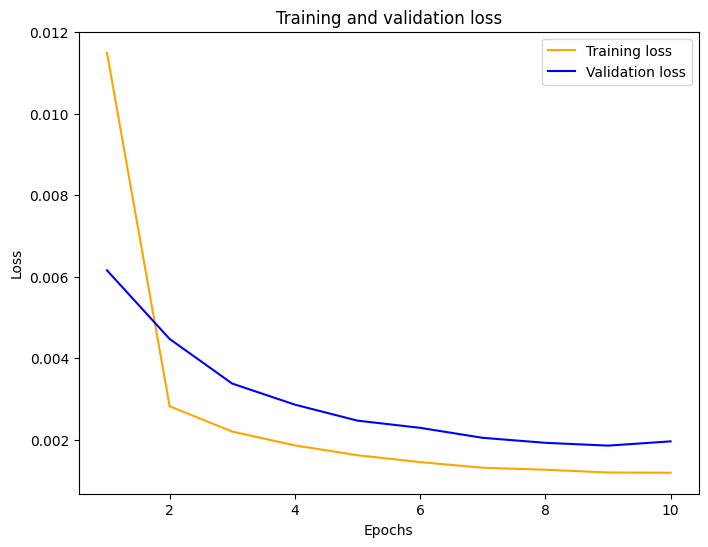

In [28]:
plot_curve(hist1)

In [29]:
predict_scaled1 = model_2.predict(X_test1)
predict1 = sc1.inverse_transform(predict_scaled1)

10/10 [==============================] - 1s 3ms/step


In [30]:
test1 = test.copy()
train1 = train.copy()

In [31]:
train1.reset_index(inplace=True)
test1.reset_index(inplace=True)

In [32]:
test1['LSTM'] = predict1
test1

DateTime  cloud_cover      LSTM
0   2021-12-16 09:10:00        0.111  0.336041
1   2021-12-16 09:11:00        0.112  0.157528
2   2021-12-16 09:12:00        0.116  0.132660
3   2021-12-16 09:13:00        0.112  0.134044
4   2021-12-16 09:14:00        0.099  0.130576
..                  ...          ...       ...
288 2021-12-16 13:58:00        0.168  0.178840
289 2021-12-16 13:59:00        0.169  0.178487
290 2021-12-16 14:00:00        0.147  0.179188
291 2021-12-16 14:01:00        0.145  0.162238
292 2021-12-16 14:02:00        0.144  0.157302

[293 rows x 3 columns]

In [33]:
plot_test(train1,test1)

In [34]:
lstm_mse_error1 = mean_squared_error(test1['cloud_cover'], test1['LSTM'], squared=True)
print(f'MSE Error of lags 10 : {lstm_mse_error1}')

MSE Error of lags 10 : 0.0019459555199504966


---

## Lag 15

In [35]:
# X_train, y_train, X_test and y_test
X_train2, y_train2, X_test2, y_test2, sc2 = Xtrain_ytrain(train,test,15)

X_train Shape : (14753, 15, 1)
y_train Shape : (14753, 1)
X_test Shape :  (293, 15, 1)
y_test Shape :  (293, 1)


c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



### Optimizer adam first layer 100 batch size 32 epochs 10 

In [36]:
model_3 = Sequential()
model_3.add(LSTM(units = 100, return_sequences = False, input_shape = (X_train2.shape[1], 1)))
model_3.add(Dense(units = 1))
model_3.compile(optimizer = 'adam', loss = 'mean_squared_error')
hist2 = model_3.fit(X_train2, y_train2, validation_data=(X_test2, y_test2), epochs = 10, batch_size = 32)

Epoch 1/10
462/462 [==============================] - 13s 16ms/step - loss: 0.0073 - val_loss: 0.0050
Epoch 2/10
462/462 [==============================] - 6s 13ms/step - loss: 0.0025 - val_loss: 0.0041
Epoch 3/10
462/462 [==============================] - 7s 16ms/step - loss: 0.0019 - val_loss: 0.0029
Epoch 4/10
462/462 [==============================] - 5s 12ms/step - loss: 0.0015 - val_loss: 0.0023
Epoch 5/10
462/462 [==============================] - 7s 14ms/step - loss: 0.0013 - val_loss: 0.0020
Epoch 6/10
462/462 [==============================] - 7s 15ms/step - loss: 0.0012 - val_loss: 0.0022
Epoch 7/10
462/462 [==============================] - 6s 14ms/step - loss: 0.0012 - val_loss: 0.0019
Epoch 8/10
462/462 [==============================] - 6s 12ms/step - loss: 0.0012 - val_loss: 0.0018
Epoch 9/10
462/462 [==============================] - 6s 12ms/step - loss: 0.0012 - val_loss: 0.0018
Epoch 10/10
462/462 [==============================] - 6s 12ms/step - loss: 0.0012 - val_l

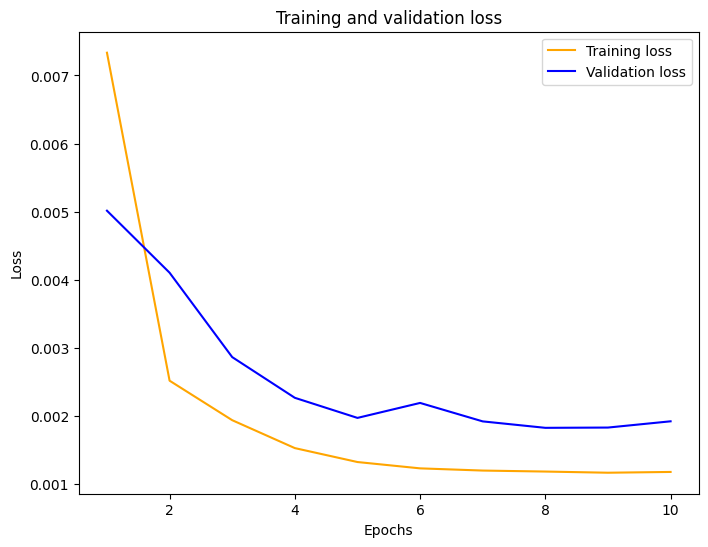

In [37]:
plot_curve(hist2)

In [38]:
predict_scaled2 = model_3.predict(X_test2)
predict2 = sc2.inverse_transform(predict_scaled2)

10/10 [==============================] - 1s 4ms/step


In [39]:
train2 = train.copy()
test2 = test.copy()

In [40]:
train2.reset_index(inplace=True)
test2.reset_index(inplace=True)

In [41]:
test2['LSTM'] = predict2
test2

DateTime  cloud_cover      LSTM
0   2021-12-16 09:10:00        0.111  0.337072
1   2021-12-16 09:11:00        0.112  0.137297
2   2021-12-16 09:12:00        0.116  0.115409
3   2021-12-16 09:13:00        0.112  0.118079
4   2021-12-16 09:14:00        0.099  0.115909
..                  ...          ...       ...
288 2021-12-16 13:58:00        0.168  0.172624
289 2021-12-16 13:59:00        0.169  0.172376
290 2021-12-16 14:00:00        0.147  0.173254
291 2021-12-16 14:01:00        0.145  0.153770
292 2021-12-16 14:02:00        0.144  0.149227

[293 rows x 3 columns]

In [42]:
plot_test(train2,test2)

In [43]:
lstm_mse_error2 = mean_squared_error(test2['cloud_cover'], test2['LSTM'], squared=True)
print(f'MSE Error of lags 15 : {lstm_mse_error2}')

MSE Error of lags 15 : 0.0019062170468862136


---

## Lag 20

In [44]:
# X_train, y_train, X_test and y_test
X_train3, y_train3, X_test3, y_test3, sc3 = Xtrain_ytrain(train,test,20)

X_train Shape : (14748, 20, 1)
y_train Shape : (14748, 1)
X_test Shape :  (293, 20, 1)
y_test Shape :  (293, 1)


c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



### Optimizer adam first layer 100 batch size 32 epochs 10

In [45]:
model_4 = Sequential()
model_4.add(LSTM(units = 100, return_sequences = False, input_shape = (X_train3.shape[1], 1)))
model_4.add(Dense(units = 1))
model_4.compile(optimizer = 'adam', loss = 'mean_squared_error')
hist3 = model_4.fit(X_train3, y_train3, validation_data=(X_test3, y_test3), epochs = 10, batch_size = 32)

Epoch 1/10
461/461 [==============================] - 12s 19ms/step - loss: 0.0086 - val_loss: 0.0054
Epoch 2/10
461/461 [==============================] - 9s 20ms/step - loss: 0.0025 - val_loss: 0.0038
Epoch 3/10
461/461 [==============================] - 8s 17ms/step - loss: 0.0019 - val_loss: 0.0031
Epoch 4/10
461/461 [==============================] - 7s 16ms/step - loss: 0.0016 - val_loss: 0.0024
Epoch 5/10
461/461 [==============================] - 9s 19ms/step - loss: 0.0014 - val_loss: 0.0021
Epoch 6/10
461/461 [==============================] - 8s 17ms/step - loss: 0.0013 - val_loss: 0.0020
Epoch 7/10
461/461 [==============================] - 8s 17ms/step - loss: 0.0012 - val_loss: 0.0018
Epoch 8/10
461/461 [==============================] - 7s 16ms/step - loss: 0.0012 - val_loss: 0.0019
Epoch 9/10
461/461 [==============================] - 7s 16ms/step - loss: 0.0012 - val_loss: 0.0018
Epoch 10/10
461/461 [==============================] - 7s 16ms/step - loss: 0.0012 - val_l

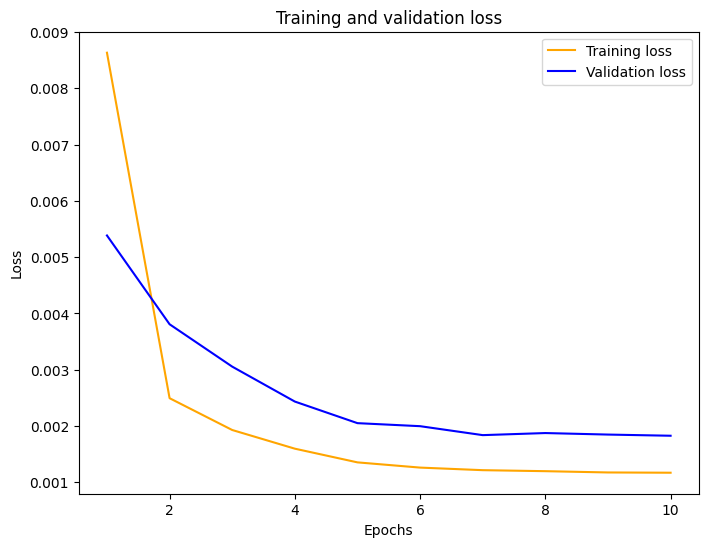

In [46]:
plot_curve(hist3)

In [47]:
predict_scaled3 = model_4.predict(X_test3)
predict3 = sc3.inverse_transform(predict_scaled3)

10/10 [==============================] - 1s 6ms/step


In [48]:
train3 = train.copy()
test3 = test.copy()

In [49]:
train3.reset_index(inplace=True)
test3.reset_index(inplace=True)

In [50]:
test3['LSTM'] = predict3
test3

DateTime  cloud_cover      LSTM
0   2021-12-16 09:10:00        0.111  0.326207
1   2021-12-16 09:11:00        0.112  0.128739
2   2021-12-16 09:12:00        0.116  0.124151
3   2021-12-16 09:13:00        0.112  0.124031
4   2021-12-16 09:14:00        0.099  0.118058
..                  ...          ...       ...
288 2021-12-16 13:58:00        0.168  0.168914
289 2021-12-16 13:59:00        0.169  0.168817
290 2021-12-16 14:00:00        0.147  0.169686
291 2021-12-16 14:01:00        0.145  0.149778
292 2021-12-16 14:02:00        0.144  0.147200

[293 rows x 3 columns]

In [51]:
plot_test(train3,test3)

In [52]:
lstm_mse_error3 = mean_squared_error(test3['cloud_cover'], test3['LSTM'], squared=True)
print(f'MSE Error of lags 20 : {lstm_mse_error3}')

MSE Error of lags 20 : 0.001817732496636008


---

## Lag 25

In [53]:
# X_train, y_train, X_test and y_test
X_train4, y_train4, X_test4, y_test4, sc4 = Xtrain_ytrain(train,test,25)

X_train Shape : (14743, 25, 1)
y_train Shape : (14743, 1)
X_test Shape :  (293, 25, 1)
y_test Shape :  (293, 1)


c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



### Optimizer adam first layer 50 batch size 32 learning rate 0.005 epochs 10 

In [54]:
model_5 = Sequential()
model_5.add(LSTM(units = 50, return_sequences = False, input_shape = (X_train4.shape[1], 1)))
model_5.add(Dense(units = 1))
opt = optimizers.Adam(learning_rate=0.005)
model_5.compile(optimizer = opt, loss = 'mean_squared_error')
hist4 = model_5.fit(X_train4, y_train4, validation_data=(X_test4, y_test4), epochs = 10, batch_size = 32)

Epoch 1/10
461/461 [==============================] - 12s 20ms/step - loss: 0.0048 - val_loss: 0.0031
Epoch 2/10
461/461 [==============================] - 7s 14ms/step - loss: 0.0016 - val_loss: 0.0021
Epoch 3/10
461/461 [==============================] - 6s 14ms/step - loss: 0.0012 - val_loss: 0.0019
Epoch 4/10
461/461 [==============================] - 6s 13ms/step - loss: 0.0012 - val_loss: 0.0019
Epoch 5/10
461/461 [==============================] - 6s 13ms/step - loss: 0.0012 - val_loss: 0.0018
Epoch 6/10
461/461 [==============================] - 6s 14ms/step - loss: 0.0012 - val_loss: 0.0018
Epoch 7/10
461/461 [==============================] - 6s 13ms/step - loss: 0.0012 - val_loss: 0.0018
Epoch 8/10
461/461 [==============================] - 6s 13ms/step - loss: 0.0012 - val_loss: 0.0019
Epoch 9/10
461/461 [==============================] - 6s 14ms/step - loss: 0.0012 - val_loss: 0.0020
Epoch 10/10
461/461 [==============================] - 6s 13ms/step - loss: 0.0012 - val_l

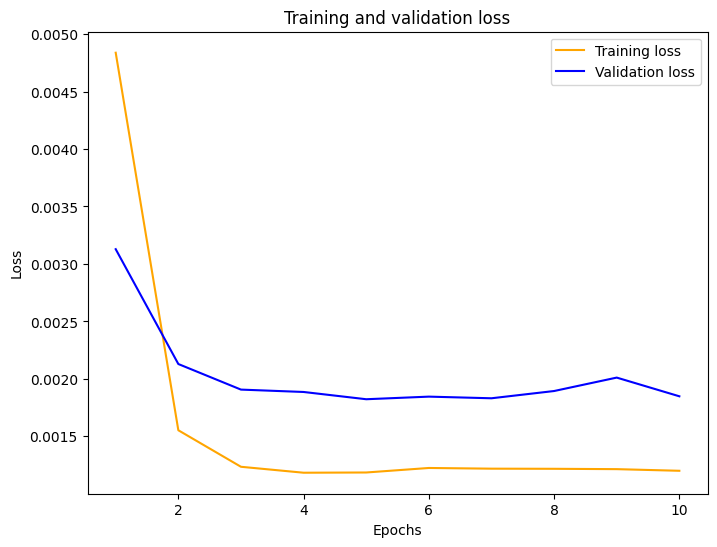

In [55]:
plot_curve(hist4)

In [56]:
predict_scaled4 = model_5.predict(X_test4)
predict4 = sc4.inverse_transform(predict_scaled4)

10/10 [==============================] - 1s 5ms/step


In [57]:
train4 = train.copy()
test4 = test.copy()

In [58]:
train4.reset_index(inplace=True)
test4.reset_index(inplace=True)

In [59]:
test4['LSTM'] = predict4
test4

DateTime  cloud_cover      LSTM
0   2021-12-16 09:10:00        0.111  0.316851
1   2021-12-16 09:11:00        0.112  0.118987
2   2021-12-16 09:12:00        0.116  0.111001
3   2021-12-16 09:13:00        0.112  0.110652
4   2021-12-16 09:14:00        0.099  0.105736
..                  ...          ...       ...
288 2021-12-16 13:58:00        0.168  0.160938
289 2021-12-16 13:59:00        0.169  0.160927
290 2021-12-16 14:00:00        0.147  0.161826
291 2021-12-16 14:01:00        0.145  0.141426
292 2021-12-16 14:02:00        0.144  0.139054

[293 rows x 3 columns]

In [60]:
plot_test(train4,test4)

In [61]:
lstm_mse_error4 = mean_squared_error(test4['cloud_cover'], test4['LSTM'], squared=True)
print(f'MSE Error of lags 25 : {lstm_mse_error4}')

MSE Error of lags 25 : 0.0018390008942205177


---

## Lag 30

In [62]:
# X_train, y_train, X_test and y_test
X_train5, y_train5, X_test5, y_test5, sc5 = Xtrain_ytrain(train,test,30)

X_train Shape : (14738, 30, 1)
y_train Shape : (14738, 1)
X_test Shape :  (293, 30, 1)
y_test Shape :  (293, 1)


c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



### Add frist layer units = 50 batch size 32  epochs 10

In [63]:
model_6 = Sequential()
model_6.add(LSTM(units = 50, return_sequences = False, input_shape = (X_train5.shape[1], 1)))
model_6.add(Dense(units = 1))
model_6.compile(optimizer = 'adam', loss = 'mean_squared_error')
hist5 = model_6.fit(X_train5, y_train5, validation_data=(X_test5, y_test5), epochs = 10, batch_size = 32)

Epoch 1/10
461/461 [==============================] - 11s 17ms/step - loss: 0.0093 - val_loss: 0.0052
Epoch 2/10
461/461 [==============================] - 7s 14ms/step - loss: 0.0024 - val_loss: 0.0037
Epoch 3/10
461/461 [==============================] - 7s 14ms/step - loss: 0.0019 - val_loss: 0.0030
Epoch 4/10
461/461 [==============================] - 7s 15ms/step - loss: 0.0016 - val_loss: 0.0025
Epoch 5/10
461/461 [==============================] - 7s 15ms/step - loss: 0.0014 - val_loss: 0.0022
Epoch 6/10
461/461 [==============================] - 7s 15ms/step - loss: 0.0013 - val_loss: 0.0020
Epoch 7/10
461/461 [==============================] - 8s 16ms/step - loss: 0.0012 - val_loss: 0.0020
Epoch 8/10
461/461 [==============================] - 8s 18ms/step - loss: 0.0012 - val_loss: 0.0019
Epoch 9/10
461/461 [==============================] - 8s 18ms/step - loss: 0.0012 - val_loss: 0.0019
Epoch 10/10
461/461 [==============================] - 8s 17ms/step - loss: 0.0012 - val_l

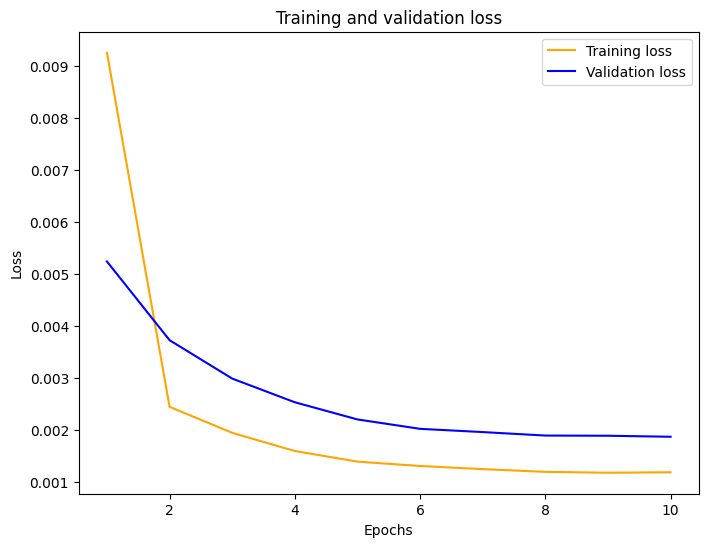

In [64]:
plot_curve(hist5)

In [65]:
predict_scaled5 = model_6.predict(X_test5)
predict5 = sc5.inverse_transform(predict_scaled5)

10/10 [==============================] - 1s 7ms/step


In [66]:
train5 = train.copy()
test5 = test.copy()

In [67]:
train5.reset_index(inplace=True)
test5.reset_index(inplace=True)

In [68]:
test5['LSTM'] = predict5
test5

DateTime  cloud_cover      LSTM
0   2021-12-16 09:10:00        0.111  0.334245
1   2021-12-16 09:11:00        0.112  0.143077
2   2021-12-16 09:12:00        0.116  0.114459
3   2021-12-16 09:13:00        0.112  0.118511
4   2021-12-16 09:14:00        0.099  0.116456
..                  ...          ...       ...
288 2021-12-16 13:58:00        0.168  0.172653
289 2021-12-16 13:59:00        0.169  0.172374
290 2021-12-16 14:00:00        0.147  0.173247
291 2021-12-16 14:01:00        0.145  0.154461
292 2021-12-16 14:02:00        0.144  0.149627

[293 rows x 3 columns]

In [69]:
plot_test(train5,test5)

In [70]:
lstm_mse_error5 = mean_squared_error(test5['cloud_cover'], test5['LSTM'], squared=True)
print(f'MSE Error of lags 30 : {lstm_mse_error5}')

MSE Error of lags 30 : 0.0018564219261058294


---

# Save Model

In [71]:
model_1.save('model_lag5_test_last_day.h5')
model_2.save('model_lag10_test_last_day.h5')
model_3.save('model_lag15_test_last_day.h5')
model_4.save('model_lag20_test_last_day.h5')
model_5.save('model_lag25_test_last_day.h5')
model_6.save('model_lag30_test_last_day.h5')